In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install optuna

In [3]:
!pip install gensim

In [4]:
import optuna
import pandas as pd
import numpy as np
import gensim
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Load Dataset :

In [5]:
file_path = "/content/drive/MyDrive/DistilBERT-7-Mei/combined_dataset.csv"
df = pd.read_csv(file_path)
print(df.head())

   Unnamed: 0         Label  \
0           0  Non-bullying   
1           1  Non-bullying   
2           2      Bullying   
3           3  Non-bullying   
4           4  Non-bullying   

                                          clean_text  \
0       kaka tidur yaa sudah pagi tidak boleh capek2   
1                    makan nasi padang saja badannya   
2                         suka cukur jembut manggung   
3  hai kak isyana ngefans sekali kak isyana suka ...   
4             manusia bidadari sih herann deh cantik   

                                              String  encoded_label  
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"            1.0  
1            "makan nasi padang aja begini badannya"            1.0  
2  "yang aku suka dari dia adalah selalu cukur je...            0.0  
3  "Hai kak Isyana aku ngefans banget sama kak Is...            1.0  
4  "Manusia apa bidadari sih herann deh cantik te...            1.0  


In [6]:
print(df.shape)

(2066, 5)


# Train-Test Split :

In [7]:
X = df['clean_text'].astype(str)
y = df['encoded_label']

# LabelEncoder untuk nama kelas
le = LabelEncoder()
le.fit(df['Label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Tokenisasi dan Padding :

In [8]:
max_words = 20000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Download dan Extract file pre-trained embedding FastText :

In [9]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz

--2025-10-01 03:31:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.238.84, 13.35.238.113, 13.35.238.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.238.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G   142MB/s    in 5.6s    

2025-10-01 03:31:34 (211 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



# Import Pre-Trained embedding fastext ke framework Gensim :

In [10]:
from gensim.models import KeyedVectors

fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', binary=False)
embedding_dim = 300  # ukuran embedding dari fastText

# Membuat Embedding Matrix :

In [11]:

word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

# Optuna Model Function :

In [12]:
def create_model(trial):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ))

    # Hyperparameter tuning: GRU units
    gru_units = trial.suggest_categorical("gru_units", [64, 128, 256])
    model.add(Bidirectional(GRU(gru_units, return_sequences=False)))

    # Hyperparameter tuning: Dropout
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.6, step=0.1)
    model.add(Dropout(dropout_rate))

    # Hyperparameter tuning: Dense layer
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
    model.add(Dense(dense_units, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameter tuning: Learning rate
    learning_rate = trial.suggest_categorical("learning_rate", [1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Optuna Objective Function :

In [13]:
def objective(trial):
  model = create_model(trial)


  # Hyperparameter tuning: batch size
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

  # Hyperparameter tuning: epochs (pure Optuna)
  epochs = trial.suggest_int("epochs", 5, 30, step=5)

  # ❌ Semua callbacks (EarlyStopping dan ReduceLROnPlateau) dihapus agar epoch murni dari Optuna
  callbacks = []

  history = model.fit(
      X_train_pad, y_train,
      validation_split=0.2,
      epochs=epochs,                # ✅ dijalankan penuh sesuai Optuna
      batch_size=batch_size,
      callbacks=callbacks,
      verbose=0
  )

  val_acc = max(history.history['val_accuracy'])
  return val_acc



# Jalankan Hyperparameter Tuning (trials=20) :

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # coba 20x

print("Best trial:", study.best_trial.params)


[I 2025-10-01 03:40:16,008] A new study created in memory with name: no-name-ad8a02f1-dd08-42da-a18c-269487316c11
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-10-01 03:40:33,850] Trial 0 finished with value: 0.8821752071380615 and parameters: {'gru_units': 64, 'dropout': 0.5, 'dense_units': 32, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 5}. Best is trial 0 with value: 0.8821752071380615.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-10-01 03:40:46,379] Trial 1 finished with value: 0.8912386894226074 and parameters: {'gru_units': 64, 'dropout': 0.3, 'dense_units': 128, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 15}. Best is trial 1 with value: 0.8912386894226074.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/cor

Best trial: {'gru_units': 64, 'dropout': 0.5, 'dense_units': 64, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 10}


# Train Model dengan Best Params :

In [15]:
best_params = study.best_trial.params
print("Training dengan best params:", best_params)

final_model = create_model(study.best_trial)

# ❌ Tidak pakai callbacks sama sekali

final_model.fit(
X_train_pad, y_train,
validation_split=0.2,
epochs=best_params["epochs"],   # ✅ ambil epoch dari hasil Optuna
batch_size=best_params["batch_size"],
verbose=1
)


Training dengan best params: {'gru_units': 64, 'dropout': 0.5, 'dense_units': 64, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 10}
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6272 - loss: 0.6044 - val_accuracy: 0.7583 - val_loss: 0.7095
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8347 - loss: 0.4058 - val_accuracy: 0.8550 - val_loss: 0.3336
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8747 - loss: 0.2869 - val_accuracy: 0.8066 - val_loss: 0.4290
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9121 - loss: 0.2080 - val_accuracy: 0.8308 - val_loss: 0.4333
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9277 - loss: 0.1870 - val_accuracy: 0.8731 - val_loss: 0.4344
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9516 - loss: 0.1233 - val_accuracy: 0.8701 - val_loss: 0.4512
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9811 - loss: 0.0654 - val_accuracy: 0.8882 - val_loss: 0.3881
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9769 - loss: 0.0691 - val_accuracy: 0.8912 - val_loss: 0.

# Evaluasi hasil train model Bi-GRU + Optuna :

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

    Bullying     0.6997    0.9680    0.8123       219
Non-bullying     0.9369    0.5333    0.6797       195

    accuracy                         0.7633       414
   macro avg     0.8183    0.7507    0.7460       414
weighted avg     0.8114    0.7633    0.7498       414



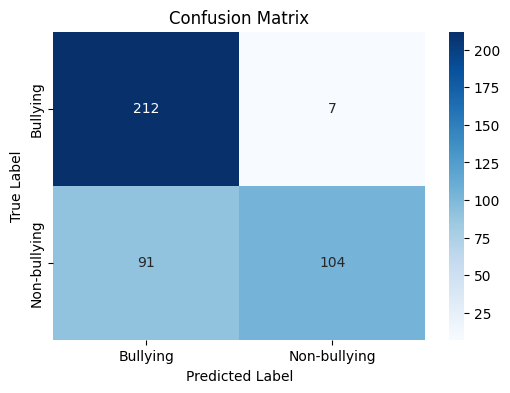

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred = (final_model.predict(X_test_pad) > 0.5).astype("int32")

# Classification Report (4 angka desimal)
class_names = le.inverse_transform([0, 1])
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
!git clone https://github.com/WilliamAxelC/Indonesian-Cyberbullying-Detection-with-Distilbert.git


Cloning into 'Indonesian-Cyberbullying-Detection-with-Distilbert'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 155 (delta 78), reused 121 (delta 44), pack-reused 0 (from 0)
Receiving objects: 100% (155/155), 15.55 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
